In [ ]:
# import packages, load function and connect to google drive
import plac
from tqdm import tqdm
import numpy as np
from PIL import Image
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pdb; 
import math
from math import nan

import sys
if 'google.colab' in sys.modules and 'torch' not in sys.modules:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

%matplotlib inline
import os

# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive', force_remount=True)

%cd "/content/drive/My Drive/Colab Notebooks/Linear_approx"


Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/Linear_approx


In [ ]:
import gc

In [ ]:
class Generator_d(nn.Module):

  def __init__(self, net_param):

    super(Generator_d, self).__init__()
    self.f = []
    for i in range(1,len(net_param)):
      net_param[i-1]
      layer = nn.Linear(net_param[i-1], net_param[i], bias = False)
      nn.init.normal_(list(layer.parameters())[0].data, 0, 1/np.sqrt(net_param[i]))
      self.f = np.append(self.f, [layer])
    
  def decoder(self, z):
    for i in range(len(self.f)):
      z = F.relu(self.f[i](z))
    return z 
  
  def forward(self, z):
    return self.decoder(z)

class Generator_linear(nn.Module):

  def __init__(self, net_param):

    super(Generator_linear, self).__init__()
    self.f = []
    for i in range(1,len(net_param)):
      net_param[i-1]
      layer = nn.Linear(net_param[i-1], net_param[i], bias = False)
      nn.init.normal_(list(layer.parameters())[0].data, 0, 1/np.sqrt(net_param[i]))
      self.f = np.append(self.f, [layer])
    
  def decoder(self, z):
    for i in range(len(self.f)):
      z = self.f[i](z)
    return z 
  
  def forward(self, z):
    return self.decoder(z)

In [ ]:
class algo_parameter:
  def __init__(self, stepsize, max_itt, tolerance):
    self.stepsize = stepsize
    self.max_itt = max_itt
    self.tolerance = tolerance
    
class weight_mats():
  W = {} # create a data struct for weight matrices
  def __init__(self, net_param):
    for i in range(len(net_param)-1):
      self.W[i] =torch.randn(net_param[i+1],net_param[i])

In [ ]:
## function that solves quasi-gradient algorithm with relative error as stopping criteria
def quasi_grad_rel(net_param, algo_param, generator, y0, weight_mats_d3, A, z0, out_toggle):
  x_dim = net_param[len(net_param)-1]
  z_dim = net_param[0]
  [m,_] = A.size()

  Wm = weight_mats_d3.W[0]
  scale = 1 # this will change if the weight matrices are not normalized
  depth = len(weight_mats_d3.W)
  for i in range(len(weight_mats_d3.W) - 1):
    Wm = torch.matmul(weight_mats_d3.W[i+1],Wm)
  zk = torch.zeros(1, z_dim).cuda()
  # zk = torch.zeros(1, z_dim)
  
  itt = 0
  rel_error = 1
  while itt < algo_param.max_itt and rel_error > algo_param.tolerance:
    xk = generator(zk).reshape(x_dim)
    d = torch.matmul(torch.t(torch.matmul(A,Wm)), torch.matmul(A,xk) -  y0.reshape(m)) * (scale**(-1))
    step = algo_param.stepsize *  d
    zk = zk - torch.t(step)
    itt += 1
    rel_error = torch.norm(z0-zk)/torch.norm(z0)

    
    if out_toggle != 0:
      if itt % ((out_toggle // 10)*10 +1) == 0:
        print('====> In quasi-gradient: Iteration: {} Relative error: {:.4e}'.format(itt, rel_error))
  if out_toggle != 0:
    print('====> In quasi-gradient: Iteration: {} Relative error: {:.4e}'.format(itt, rel_error))  
    print('')
  # pdb.set_trace()

  # del Wm
  # gc.collect() 
  return zk, itt

## function that solves quasi-gradient algorithm with successive error as stopping criteria
def quasi_grad(net_param, algo_param, generator, y0, Wm, A, out_toggle):
  x_dim = net_param[len(net_param)-1]
  z_dim = net_param[0]
  [m,_] = A.size()
  scale = 1 # this will change if the weight matrices are not normalized

  zk = torch.randn(1, z_dim).cuda()
  z_temp = zk
  
  itt = 0
  succ_error = 1
  while itt < algo_param.max_itt and succ_error > algo_param.tolerance:
    z_temp = zk - torch.t(algo_param.stepsize *  torch.matmul(torch.t(torch.matmul(A,Wm)), torch.matmul(A, generator(zk).reshape(x_dim)) -  y0.reshape(m)) * (scale**(-1)))
    itt += 1
    succ_error = torch.norm(z_temp-zk)/torch.norm(zk)
    zk.data = z_temp.data
    # pdb.set_trace()

    
    if out_toggle != 0:
      if itt % ((out_toggle // 10)*10 +1) == 0:
        print('====> In quasi-gradient: Iteration: {} Successive error: {:.4e}'.format(itt, succ_error))
  if out_toggle != 0:
    print('====> In quasi-gradient: Iteration: {} Successive error: {:.4e}'.format(itt, succ_error))  
    print('')

  return zk, itt

In [ ]:
## function that solves gradient descent algorithm withough flipping with stoping criteria as successive error
def gradient_desc(net_param, algo_param, generator, y0, A, out_toggle):
  x_dim = net_param[len(net_param)-1]
  z_dim = net_param[0]
  device = "cuda"
  z = torch.randn(z_dim, device=device, requires_grad = True)
  z_temp = torch.randn(z_dim, device=device, requires_grad = False)
  succ_error = 1
  itt = 1

  Wm = list(generator.f[0].parameters())[0].data
  for i in range(1, depth):
    Wm = torch.matmul(list(generator.f[i].parameters())[0].data,Wm)

  

  while itt < algo_param.max_itt and succ_error > algo_param.tolerance:

    z_temp.data = z.clone()
    y_pred = torch.matmul(A, generator(z).reshape(x_dim))
    loss_fn = (y_pred-y0).pow(2).mean()
    
    loss_fn.backward()

    grad_norm = torch.norm(z.grad)

    print(z.grad)

    print(2*torch.matmul(torch.t(Wm), generator(z).reshape(x_dim) -  y0.reshape(x_dim))/(x_dim*10))

    # print(torch.norm( -  z.grad) )
    with torch.no_grad():
      z -= algo_param.stepsize*z.grad
      z.grad.zero_()

    itt += 1
    succ_error = torch.norm(z_temp-z)/torch.norm(z)  
    
    # pdb.set_trace()

    if out_toggle != 0:
      if itt % ((out_toggle // 10)*10 +1) == 0:
        print('====> In gradient descent: Iteration: {} Successive error: {:.4e}'.format(itt, succ_error))

  if out_toggle != 0:
    print('====> In gradient descent: Iteration: {} Successive error: {:.4e}'.format(itt, succ_error))  
    print('')

  return z, itt

In [ ]:
x_dim = 1000
net_param = [40, 400, 500, x_dim]
depth = 3
z_dim = 20

noise_level = 0

quasi_algo_param = algo_parameter(3, 2, 1e-13) # (stepsize, max_itt, tolerance)
exact_algo_param = algo_parameter(1, 2, 1e-13) # (stepsize, max_itt, tolerance)

generator = Generator_linear(net_param)
# normalized signal
z0 = torch.randn(net_param[0]).cuda()
z0 = z0 /torch.norm(z0)

for i in range(0, depth):
  generator.f[i].cuda()
  list(generator.f[i].parameters())[0].requires_grad = False

Wm = list(generator.f[0].parameters())[0].data
for i in range(1, depth):
  Wm = torch.matmul(list(generator.f[i].parameters())[0].data,Wm)

A = torch.eye(x_dim).cuda()

# measurement for denoising
noise_direction = torch.randn(x_dim).cuda();
noise = noise_level* noise_direction/torch.norm(noise_direction);
y0 = generator(z0) +  noise;

z_exact_est, itt = gradient_desc(net_param, exact_algo_param, generator, y0, A, 10000)
error_reconst = torch.norm(generator(z0).detach()-generator(z_exact_est).detach())/ torch.norm(generator(z0).detach())
error_recov= torch.norm(z0-z_exact_est)/ torch.norm(z0)

print('====> relative error {:.4e}'.format(error_recov))


tensor([ 3.4032e-03, -7.4983e-04,  1.0259e-03,  3.8355e-04, -1.4727e-03,
        -3.0407e-03,  1.6629e-03,  7.7583e-04,  2.6121e-03,  3.6414e-04,
        -1.6699e-03, -7.3581e-04, -3.7892e-04,  2.6187e-04,  2.8214e-03,
        -1.0373e-03,  5.3983e-04, -1.7621e-03,  2.6181e-03,  4.3219e-03,
         3.5486e-03,  2.5925e-03,  9.1041e-04,  2.4770e-03, -2.1778e-03,
        -3.2634e-04,  1.6435e-03,  1.4915e-03, -1.9895e-03,  1.4266e-03,
         8.2304e-04, -3.7660e-03,  2.9830e-03,  1.3587e-03, -3.3834e-03,
         2.5000e-04, -6.8075e-04, -1.0493e-03,  1.0129e-03, -8.9520e-05],
       device='cuda:0')
tensor([ 3.4032e-04, -7.4983e-05,  1.0259e-04,  3.8355e-05, -1.4727e-04,
        -3.0407e-04,  1.6629e-04,  7.7583e-05,  2.6121e-04,  3.6414e-05,
        -1.6699e-04, -7.3581e-05, -3.7892e-05,  2.6186e-05,  2.8214e-04,
        -1.0373e-04,  5.3983e-05, -1.7621e-04,  2.6181e-04,  4.3219e-04,
         3.5486e-04,  2.5925e-04,  9.1041e-05,  2.4770e-04, -2.1778e-04,
        -3.2634e-05,  1.64

In [ ]:
tot_trials = 1
depth = 3
tot_incre = 10
noise_list = torch.linspace(.1,.1,1)

expanse_param = 20
z_dim = 20
net_param_semi = np.append([z_dim], np.ones(depth - 1)*z_dim*expanse_param)
net_param_semi = net_param_semi.astype(int)
x_dim_list = [200, 300, 400, 500, 750, 1000, 1500, 2000, 2500, 3000, 4000, 5000]

error_matrix_quasi_reconst = torch.zeros(len(noise_list), len(x_dim_list), tot_trials)
error_matrix_exact_reconst = torch.zeros(len(noise_list), len(x_dim_list), tot_trials)

error_matrix_quasi_recov = torch.zeros(len(noise_list), len(x_dim_list), tot_trials)
error_matrix_exact_recov = torch.zeros(len(noise_list), len(x_dim_list), tot_trials)

print(torch.cuda.memory_summary(device=None, abbreviated=False))

for j in range(len(noise_list)):
  noise_level = noise_list[j]
  for k in range(len(x_dim_list)):
    x_dim = x_dim_list[k]
    net_param = np.append(net_param_semi, [x_dim])
    quasi_algo_param = algo_parameter(3, 10000, 1e-13) # (stepsize, max_itt, tolerance)
    exact_algo_param = algo_parameter(3, 10000, 1e-13) # (stepsize, max_itt, tolerance)

    print('====> network parameter = {}'.format(net_param))
    for trials in range(tot_trials):  
      print('====> trial number = {}'.format(trials))

      generator = Generator_d(net_param)
      # normalized signal
      z0 = torch.randn(net_param[0]).cuda()
      z0 = z0 /torch.norm(z0)

      for i in range(0, depth):
        generator.f[i].cuda()
        list(generator.f[i].parameters())[0].requires_grad = False

      Wm = list(generator.f[0].parameters())[0].data
      for i in range(1, depth):
        Wm = torch.matmul(list(generator.f[i].parameters())[0].data,Wm)
      
      A = torch.eye(x_dim).cuda()

      # measurement for denoising
      noise_direction = torch.randn(x_dim).cuda();
      noise = noise_level* noise_direction/torch.norm(noise_direction);
      y0 = generator(z0) +  noise;

      z_quasi_est, itt = quasi_grad(net_param, quasi_algo_param, generator, y0, Wm , A, 10000)
      error_matrix_quasi_reconst[j,k, trials] = torch.norm(generator(z0).detach()-generator(z_quasi_est).detach())/ torch.norm(generator(z0).detach())
      error_matrix_quasi_recov[j,k, trials] = torch.norm(z0-z_quasi_est)/ torch.norm(z0)

      z_exact_est, itt = gradient_desc(net_param, exact_algo_param, generator, y0, A, 10000)
      error_matrix_exact_reconst[j,k, trials] = torch.norm(generator(z0).detach()-generator(z_exact_est).detach())/ torch.norm(generator(z0).detach())
      error_matrix_exact_recov[j,k, trials] = torch.norm(z0-z_exact_est)/ torch.norm(z0)


torch.save(error_matrix_quasi_recov,"/content/drive/My Drive/Colab Notebooks/Linear_approx/Results/Non_expanse_error_decay_recovery_quasi.pt")
torch.save(error_matrix_quasi_reconst,"/content/drive/My Drive/Colab Notebooks/Linear_approx/Results/Non_expanse_error_decay_reconst_quasi.pt")

torch.save(error_matrix_exact_recov,"/content/drive/My Drive/Colab Notebooks/Linear_approx/Results/Non_expanse_error_decay_recovery_exact.pt")
torch.save(error_matrix_exact_reconst,"/content/drive/My Drive/Colab Notebooks/Linear_approx/Results/Non_expanse_error_decay_reconst_exact.pt")


sampling_ratio = np.sqrt([z_dim/x_out for x_out in x_dim_list])

noise_level = .1

fig, (ax1, ax2) = plt.subplots(2,1)
error_matrix_quasi_entry = error_matrix_quasi_recov[0] 
quasi_mean = np.mean(error_matrix_quasi_entry.detach().numpy(), axis=1)
quasi_std = np.std(error_matrix_quasi_entry.detach().numpy(), axis=1)
ax1.plot(sampling_ratio, quasi_mean)
ax1.fill( np.append(sampling_ratio, np.flip(sampling_ratio)), np.append(quasi_mean - quasi_std, np.flip(quasi_mean + quasi_std)), alpha = .2)

error_matrix_exact_entry = error_matrix_exact_reconst[0] 
exact_mean = np.mean(error_matrix_exact_entry.detach().numpy(), axis=1)
exact_std = np.std(error_matrix_exact_entry.detach().numpy(), axis=1)
ax1.plot(sampling_ratio, exact_mean)
ax1.fill( np.append(sampling_ratio, np.flip(sampling_ratio)), np.append(exact_mean - exact_std, np.flip(exact_mean + exact_std)), alpha = .2)
ax1.plot(sampling_ratio, [numbers*12*noise_level for numbers in sampling_ratio], '--')
ax1.set(xlabel = "Square root of expansion ratio, $\sqrt{n_0/n_d}$", ylabel= "Relative error")

error_matrix_quasi_entry = error_matrix_quasi_recov[0] 
quasi_mean = np.mean(error_matrix_quasi_entry.detach().numpy(), axis=1)
quasi_std = np.std(error_matrix_quasi_entry.detach().numpy(), axis=1)
ax2.plot(sampling_ratio, quasi_mean)
ax2.fill( np.append(sampling_ratio, np.flip(sampling_ratio)), np.append(quasi_mean - quasi_std, np.flip(quasi_mean + quasi_std)), alpha = .2)

error_matrix_exact_entry = error_matrix_exact_recov[0] 
exact_mean = np.mean(error_matrix_exact_entry.detach().numpy(), axis=1)
exact_std = np.std(error_matrix_exact_entry.detach().numpy(), axis=1)
ax2.plot(sampling_ratio, exact_mean)
ax2.fill( np.append(sampling_ratio, np.flip(sampling_ratio)), np.append(exact_mean - exact_std, np.flip(exact_mean + exact_std)), alpha = .2)
ax2.plot(sampling_ratio, [numbers*12*noise_level for numbers in sampling_ratio], '--')
ax2.set(xlabel = "Square root of expansion ratio, $\sqrt{n_0/n_d}$", ylabel= "Relative error")

# plt.savefig("Results/Non_Expanse_noise_decay.png", bbox_inches='tight', dpi=300)




NameError: ignored

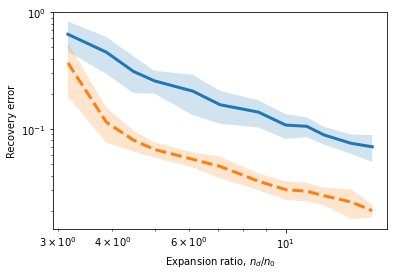

In [ ]:
error_matrix_quasi_recov = torch.load("/content/drive/My Drive/Colab Notebooks/Linear_approx/Results/Non_expanse_error_decay_recovery_quasi.pt")
error_matrix_quasi_reconst = torch.load("/content/drive/My Drive/Colab Notebooks/Linear_approx/Results/Non_expanse_error_decay_reconst_quasi.pt")

error_matrix_exact_recov = torch.load("/content/drive/My Drive/Colab Notebooks/Linear_approx/Results/Non_expanse_error_decay_recovery_exact.pt")
error_matrix_exact_reconst = torch.load("/content/drive/My Drive/Colab Notebooks/Linear_approx/Results/Non_expanse_error_decay_reconst_exact.pt")

x_dim_list = [200, 300, 400, 500, 750, 1000, 1500, 2000, 2500, 3000, 4000, 5000]
z_dim = 20

#Plotting
sampling_ratio = np.sqrt([x_out/z_dim for x_out in x_dim_list])

noise_level = .1

# fig, ax2 = plt.subplots(1,1)
# error_matrix_quasi_entry = error_matrix_quasi_reconst[0] 
# quasi_mean = np.mean(error_matrix_quasi_entry.detach().numpy(), axis=1)
# quasi_std = np.std(error_matrix_quasi_entry.detach().numpy(), axis=1)
# ax2.loglog(sampling_ratio, quasi_mean, linewidth=3)
# ax2.fill( np.append(sampling_ratio, np.flip(sampling_ratio)), np.append(quasi_mean - quasi_std, np.flip(quasi_mean + quasi_std)), alpha = .2)

# error_matrix_exact_entry = error_matrix_exact_reconst[0] 
# exact_mean = np.mean(error_matrix_exact_entry.detach().numpy(), axis=1)
# exact_std = np.std(error_matrix_exact_entry.detach().numpy(), axis=1)
# ax2.loglog(sampling_ratio, exact_mean, '--', linewidth=3)
# ax2.fill( np.append(sampling_ratio, np.flip(sampling_ratio)), np.append(exact_mean - exact_std, np.flip(exact_mean + exact_std)), alpha = .2)
# plt.xlabel("Expansion ratio, $n_d/n_0$")
# plt.ylabel("Reconstruction error")

# plt.savefig("Results/Noise_decay_static_reconst.png", bbox_inches='tight', dpi=300)

fig, ax1 = plt.subplots(1,1)
error_matrix_quasi_entry = error_matrix_quasi_recov[0] 
quasi_mean = np.mean(error_matrix_quasi_entry.detach().numpy(), axis=1)
quasi_std = np.std(error_matrix_quasi_entry.detach().numpy(), axis=1)
ax1.loglog(sampling_ratio, quasi_mean, '-', linewidth=3)
ax1.fill( np.append(sampling_ratio, np.flip(sampling_ratio)), np.append(quasi_mean - quasi_std, np.flip(quasi_mean + quasi_std)), alpha = .2)

error_matrix_exact_entry = error_matrix_exact_recov[0] 
exact_mean = np.mean(error_matrix_exact_entry.detach().numpy(), axis=1)
exact_std = np.std(error_matrix_exact_entry.detach().numpy(), axis=1)
ax1.loglog(sampling_ratio, exact_mean,'--',linewidth=3)
ax1.fill( np.append(sampling_ratio, np.flip(sampling_ratio)), np.append(exact_mean - exact_std, np.flip(exact_mean + exact_std)), alpha = .2)
# ax1.loglog(sampling_ratio, [numbers*10*noise_level for numbers in sampling_ratio], '-')
plt.xlabel("Expansion ratio, $n_d/n_0$")
plt.ylabel("Recovery error")
plt.savefig("Results/Noise_decay_static_recov.png", bbox_inches='tight', dpi=300)


====> network parameter = [20, 600, 500, 500]
====> noiselevel = 0.0000e+00, recovery error = 9.7916e-08, reconstruction error = 2.0183e-07
====> noiselevel = 5.2632e-02, recovery error = 2.9141e-02, reconstruction error = 2.8263e-02
====> noiselevel = 1.0526e-01, recovery error = 4.1267e-02, reconstruction error = 4.2445e-02
====> noiselevel = 1.5789e-01, recovery error = 1.0064e-01, reconstruction error = 1.0486e-01
====> noiselevel = 2.1053e-01, recovery error = 1.5497e-01, reconstruction error = 1.4759e-01
====> noiselevel = 2.6316e-01, recovery error = 1.3955e-01, reconstruction error = 1.3330e-01
====> noiselevel = 3.1579e-01, recovery error = 1.6062e-01, reconstruction error = 1.5099e-01
====> noiselevel = 3.6842e-01, recovery error = 2.1606e-01, reconstruction error = 1.8589e-01
====> noiselevel = 4.2105e-01, recovery error = 3.9588e-01, reconstruction error = 3.3454e-01
====> noiselevel = 4.7368e-01, recovery error = 4.6826e-01, reconstruction error = 3.9063e-01
====> noiselev

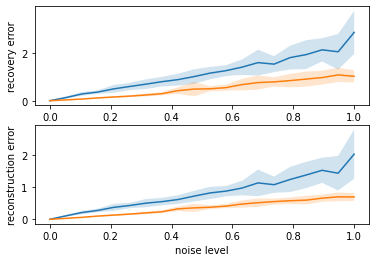

In [ ]:
tot_trials = 20
noise_level_list = torch.linspace(0, 1, 20)
error_matrix_quasi_recov = torch.zeros(len(noise_level_list), tot_trials)
error_matrix_exact_recov = torch.zeros(len(noise_level_list), tot_trials)

error_matrix_quasi_reconst = torch.zeros(len(noise_level_list), tot_trials)
error_matrix_exact_reconst = torch.zeros(len(noise_level_list), tot_trials)

expanse_param = 5
z_dim = 20
net_param = [z_dim, 600, 500, 500]
x_dim = net_param[len(net_param)-1]
depth = 3
quasi_algo_param = algo_parameter(3, 10000, 1e-13) # (stepsize, max_itt, tolerance)
exact_algo_param = algo_parameter(1000, 10000, 1e-13) # (stepsize, max_itt, tolerance)
print('====> network parameter = {}'.format(net_param))
for trials in range(tot_trials):
  generator = Generator_d(net_param)

  # signal
  z0 = torch.randn(1, net_param[0]).cuda()
  z0 = z0/torch.norm(z0)

  for i in range(0, depth):
    generator.f[i].cuda()
    list(generator.f[i].parameters())[0].requires_grad = False

  Wm = list(generator.f[0].parameters())[0].data
  for i in range(1, depth):
    Wm = torch.matmul(list(generator.f[i].parameters())[0].data,Wm)

  x_dim = net_param[len(net_param) -1]
  A = torch.eye(net_param[len(net_param) - 1]).cuda()

  for noise_level_idx in range(len(noise_level_list)):

    noise_level = noise_level_list[noise_level_idx]

    # measurement for denoising
    noise_direction = torch.randn(1, x_dim).cuda();
    noise = noise_level* noise_direction/torch.norm(noise_direction);
    y0 = generator(z0) +  noise;

    z_quasi_est, itt = quasi_grad(net_param, quasi_algo_param, generator, y0, Wm , A, 0)
    error_matrix_quasi_recov[noise_level_idx, trials] = torch.norm(z0-z_quasi_est)/ torch.norm(z0)
    error_matrix_quasi_reconst[noise_level_idx, trials] = torch.norm(generator(z0).detach()-generator(z_quasi_est).detach())/ torch.norm(generator(z0).detach())

    z_exact_est, itt =gradient_desc(net_param, exact_algo_param, generator, y0, A, 0)
    error_matrix_exact_recov[noise_level_idx, trials] = torch.norm(z0-z_exact_est)/ torch.norm(z0)  
    error_matrix_exact_reconst[noise_level_idx, trials] = torch.norm(generator(z0).detach()-generator(z_exact_est).detach())/ torch.norm(generator(z0).detach())

    print('====> noiselevel = {:.4e}, recovery error = {:.4e}, reconstruction error = {:.4e}'.format(noise_level,torch.norm(z0-z_exact_est)/ torch.norm(z0), torch.norm(generator(z0).detach()-generator(z_exact_est).detach())/ torch.norm(generator(z0).detach()) ))

torch.save(error_matrix_quasi_recov,"/content/drive/My Drive/Colab Notebooks/Linear_approx/Results/Contraction_linear_noise_recovery_quasi.pt")
torch.save(error_matrix_quasi_reconst,"/content/drive/My Drive/Colab Notebooks/Linear_approx/Results/Contraction_linear_noise_reconst_quasi.pt")

torch.save(error_matrix_exact_recov,"/content/drive/My Drive/Colab Notebooks/Linear_approx/Results/Contraction_linear_noise_recovery_exact.pt")
torch.save(error_matrix_exact_reconst,"/content/drive/My Drive/Colab Notebooks/Linear_approx/Results/Contraction_linear_noise_reconst_exact.pt")

fig, (ax1, ax2) = plt.subplots(2,1)
quasi_mean = np.mean(error_matrix_quasi_recov.numpy(), axis=1)
quasi_std = np.std(error_matrix_quasi_recov.numpy(), axis=1)
ax1.plot(noise_level_list.numpy(), quasi_mean)
ax1.fill( np.append(noise_level_list.numpy(), np.flip(noise_level_list.numpy())), np.append(quasi_mean - quasi_std, np.flip(quasi_mean + quasi_std)), alpha = .2)
ax1.set(ylabel = "recovery error")


exact_mean = np.mean(error_matrix_exact_recov.detach().numpy(), axis=1)
exact_std = np.std(error_matrix_exact_recov.detach().numpy(), axis=1)
ax1.plot(noise_level_list.numpy(), exact_mean)
ax1.fill( np.append(noise_level_list.numpy(), np.flip(noise_level_list.numpy())), np.append(exact_mean  - exact_std, np.flip(exact_mean + exact_std)), alpha = .2)

quasi_mean = np.mean(error_matrix_quasi_reconst.numpy(), axis=1)
quasi_std = np.std(error_matrix_quasi_reconst.numpy(), axis=1)
ax2.plot(noise_level_list.numpy(), quasi_mean)
ax2.fill( np.append(noise_level_list.numpy(), np.flip(noise_level_list.numpy())), np.append(quasi_mean - quasi_std, np.flip(quasi_mean + quasi_std)), alpha = .2)
ax2.set(xlabel = "noise level", ylabel = "reconstruction error")


exact_mean = np.mean(error_matrix_exact_reconst.detach().numpy(), axis=1)
exact_std = np.std(error_matrix_exact_reconst.detach().numpy(), axis=1)
ax2.plot(noise_level_list.numpy(), exact_mean)
ax2.fill( np.append(noise_level_list.numpy(), np.flip(noise_level_list.numpy())), np.append(exact_mean  - exact_std, np.flip(exact_mean + exact_std)), alpha = .2)

plt.savefig("/content/drive/My Drive/Colab Notebooks/Linear_approx/non_expansive_comp.png", bbox_inches='tight', dpi=300)



In [ ]:
sampling_ratio

array([ 3.16227766,  3.87298335,  4.47213595,  5.        ,  6.12372436,
        7.07106781,  8.66025404, 10.        , 11.18033989, 12.24744871,
       14.14213562, 15.8113883 ])

ValueError: ignored

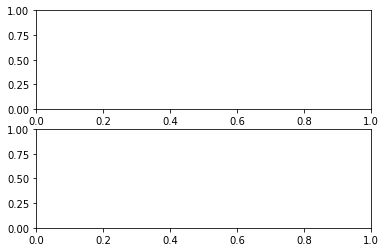

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1)
quasi_mean = np.mean(error_matrix_quasi_recov.numpy(), axis=1)
quasi_std = np.std(error_matrix_quasi_recov.numpy(), axis=1)
ax1.plot(noise_level_list.numpy(), quasi_mean)
ax1.fill( np.append(noise_level_list.numpy(), np.flip(noise_level_list.numpy())), np.append(quasi_mean - quasi_std, np.flip(quasi_mean + quasi_std)), alpha = .2)
ax1.set(ylabel = "Recovery error")


exact_mean = np.mean(error_matrix_exact_recov.detach().numpy(), axis=1)
exact_std = np.std(error_matrix_exact_recov.detach().numpy(), axis=1)
ax1.plot(noise_level_list.numpy(), exact_mean)
ax1.fill( np.append(noise_level_list.numpy(), np.flip(noise_level_list.numpy())), np.append(exact_mean  - exact_std, np.flip(exact_mean + exact_std)), alpha = .2)

quasi_mean = np.mean(error_matrix_quasi_reconst.numpy(), axis=1)
quasi_std = np.std(error_matrix_quasi_reconst.numpy(), axis=1)
ax2.plot(noise_level_list.numpy(), quasi_mean)
ax2.fill( np.append(noise_level_list.numpy(), np.flip(noise_level_list.numpy())), np.append(quasi_mean - quasi_std, np.flip(quasi_mean + quasi_std)), alpha = .2)
ax2.set(xlabel = "Noise to signal ratio", ylabel = "Reconstruction error")


exact_mean = np.mean(error_matrix_exact_reconst.detach().numpy(), axis=1)
exact_std = np.std(error_matrix_exact_reconst.detach().numpy(), axis=1)
ax2.plot(noise_level_list.numpy(), exact_mean)
ax2.fill( np.append(noise_level_list.numpy(), np.flip(noise_level_list.numpy())), np.append(exact_mean  - exact_std, np.flip(exact_mean + exact_std)), alpha = .2)

In [ ]:
torch.save(error_matrix_quasi_recov,"/content/drive/My Drive/Colab Notebooks/Linear_approx/Results/Contraction_linear_noise_recovery.pt")
torch.save(error_matrix_quasi_reconst,"/content/drive/My Drive/Colab Notebooks/Linear_approx/Results/Contraction_linear_noise_reconst.pt")

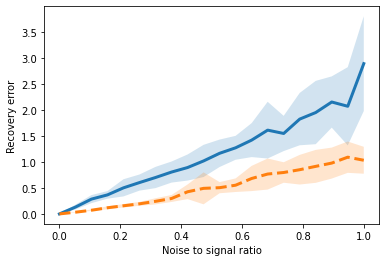

In [ ]:
tot_trials = 20
noise_level_list = torch.linspace(0, 1, 20)

expanse_param = 5
z_dim = 20
net_param = [z_dim, 600, 500, 500]
x_dim = net_param[len(net_param)-1]
depth = 3

error_matrix_quasi_recov=torch.load("/content/drive/My Drive/Colab Notebooks/Linear_approx/Results/Contraction_linear_noise_recovery_quasi.pt")
error_matrix_quasi_reconst =torch.load("/content/drive/My Drive/Colab Notebooks/Linear_approx/Results/Contraction_linear_noise_reconst_quasi.pt")

error_matrix_exact_recov =torch.load("/content/drive/My Drive/Colab Notebooks/Linear_approx/Results/Contraction_linear_noise_recovery_exact.pt")
error_matrix_exact_reconst= torch.load("/content/drive/My Drive/Colab Notebooks/Linear_approx/Results/Contraction_linear_noise_reconst_exact.pt")

fig1, ax1 = plt.subplots(1,1)

# fig, (ax1, ax2) = plt.subplots(2,1)
quasi_mean = np.mean(error_matrix_quasi_recov.numpy(), axis=1)
quasi_std = np.std(error_matrix_quasi_recov.numpy(), axis=1)
ax1.plot(noise_level_list.numpy(), quasi_mean, '-', linewidth=3)
ax1.fill( np.append(noise_level_list.numpy(), np.flip(noise_level_list.numpy())), np.append(quasi_mean - quasi_std, np.flip(quasi_mean + quasi_std)), alpha = .2)
ax1.set(xlabel = "Noise to signal ratio", ylabel = "Recovery error")


exact_mean = np.mean(error_matrix_exact_recov.detach().numpy(), axis=1)
exact_std = np.std(error_matrix_exact_recov.detach().numpy(), axis=1)
ax1.plot(noise_level_list.numpy(), exact_mean, '--', linewidth=3)
ax1.fill( np.append(noise_level_list.numpy(), np.flip(noise_level_list.numpy())), np.append(exact_mean  - exact_std, np.flip(exact_mean + exact_std)), alpha = .2)
plt.savefig("/content/drive/My Drive/Colab Notebooks/Linear_approx/non_expansive_comp_recov.png", bbox_inches='tight', dpi=300)

# fig, ax2 = plt.subplots(1,1)
# quasi_mean = np.mean(error_matrix_quasi_reconst.numpy(), axis=1)
# quasi_std = np.std(error_matrix_quasi_reconst.numpy(), axis=1)
# ax2.plot(noise_level_list.numpy(), quasi_mean, '-', linewidth=3)
# ax2.fill( np.append(noise_level_list.numpy(), np.flip(noise_level_list.numpy())), np.append(quasi_mean - quasi_std, np.flip(quasi_mean + quasi_std)), alpha = .2)
# ax2.set(xlabel = "Noise to signal ratio", ylabel = "Reconstruction error")


# exact_mean = np.mean(error_matrix_exact_reconst.detach().numpy(), axis=1)
# exact_std = np.std(error_matrix_exact_reconst.detach().numpy(), axis=1)
# ax2.plot(noise_level_list.numpy(), exact_mean, '--', linewidth=3)
# ax2.fill( np.append(noise_level_list.numpy(), np.flip(noise_level_list.numpy())), np.append(exact_mean  - exact_std, np.flip(exact_mean + exact_std)), alpha = .2)

# plt.savefig("/content/drive/My Drive/Colab Notebooks/Linear_approx/non_expansive_comp_reconst.png", bbox_inches='tight', dpi=300)


In [ ]:
noise_level_list

tensor([0.0000, 0.0526, 0.1053, 0.1579, 0.2105, 0.2632, 0.3158, 0.3684, 0.4211,
        0.4737, 0.5263, 0.5789, 0.6316, 0.6842, 0.7368, 0.7895, 0.8421, 0.8947,
        0.9474, 1.0000])

In [ ]:
test_error[0][0][19] = 1.5

In [ ]:
error_matrix_quasi

tensor([[[0.4685, 0.4994, 0.6877, 0.3741, 0.3274, 0.4883, 0.3381, 0.3025,
          0.6739, 0.2725, 0.1754, 0.3416, 0.3439, 0.3829, 1.1233, 0.5235,
          0.5028, 0.2713, 0.2292, 0.3060],
         [0.1940, 0.1882, 0.2055, 0.3089, 0.2622, 0.2317, 0.3316, 0.2246,
          0.2334, 0.2637, 0.1832, 0.3234, 0.2529, 0.2333, 0.2220, 0.3465,
          0.4369, 0.2092, 0.2322, 0.2435],
         [0.2369, 0.1939, 0.1832, 0.1849, 0.1516, 0.2495, 0.2712, 0.1991,
          0.2862, 0.2349, 0.1653, 0.2344, 0.2149, 0.3379, 0.2494, 0.2679,
          0.2012, 0.2084, 0.2780, 0.2110],
         [0.2890, 0.2094, 0.2685, 0.1936, 0.1726, 0.2840, 0.1613, 0.1650,
          0.1969, 0.2302, 0.2017, 0.1540, 0.4004, 0.1442, 0.1259, 0.3140,
          0.1233, 0.2378, 0.1728, 0.1518],
         [0.0839, 0.1719, 0.1670, 0.1447, 0.2048, 0.1070, 0.1464, 0.1655,
          0.1664, 0.1779, 0.1526, 0.1137, 0.1743, 0.1697, 0.1257, 0.0894,
          0.1699, 0.1955, 0.1674, 0.1329],
         [0.1385, 0.1362, 0.1133, 0.1426, 0.1